#### Data Load

In [1]:
%pylab inline
import umap

Populating the interactive namespace from numpy and matplotlib


In [2]:
phy=open("distances.phyllip","r")

ids_dist=["10078716"]
distances=np.zeros((967,967))
z=1
i=-1
for line in phy:
    if i<1:
        i+=1
        continue
    line=line.strip("\n").split("\t")
    ids_dist.append(line.pop(0).split("/")[1].split("_")[0])
    for j in range(len(line)):
        distances[i,j]=line[j]
        distances[j,i]=line[j]
    i+=1
    z+=1
phy.close()

In [3]:
mapping=open("Proj_UID.csv","r")
projects=[]
ids_map=[]
cols=[]
z=0
first=1
i=1
for line in mapping:
    #print(cols)
    line=line.strip("\n").split(";")
    ids_map.append(line[0])
    i+=1
    if first==1:
        projects.append(line[1])
        cols.append(z)
        z+=1
        first=0
    else:
        if line[1] in projects:
            cols.append(projects.index(line[1]))
        else:
            projects.append(line[1])
            cols.append(z)
            z+=1
mapping.close()

In [4]:
for i in range(len(ids_map)):
    print(ids_map[i]+"    "+ids_dist[i])

10078716    10078716
10079387    10079387
10086284    10086284
10528116    10528116
10528118    10528118
10528120    10528120
10528125    10528125
10551357    10551357
10551362    10551362
10551364    10551364
10551365    10551365
10917673    10917673
10917676    10917676
10917678    10917678
10917683    10917683
10917684    10917684
11521461    11521461
11521462    11521462
11521465    11521465
11521731    11521731
11521737    11521737
11521743    11521743
11521745    11521745
11521746    11521746
11521748    11521748
11521749    11521749
11521797    11521797
11521805    11521805
11555769    11555769
11555935    11555935
11562833    11562833
11562906    11562906
11562912    11562912
11562924    11562924
11562925    11562925
11562928    11562928
11562947    11562947
11563019    11563019
11576068    11576068
279982    279982
30867    30867
30868    30868
333762    333762
5355178    5355178
5361648    5361648
5410302    5410302
5410307    5410307
5410309    5410309
5410316    5410316
541

In [5]:
fpapers=open("Papers-Grid_Min.csv","r",encoding="utf-8")

ProjforKeywords=[]
keywords=[]

for line in fpapers:
    if "PRJNA" in line:
        line=line.strip("\n").split('PRJNA')
        projectID="PRJNA"+line[1].split(",")[0].split(";")[0].split(".pdf")[0].split(")")[0]
        if projectID in projects:
            ProjforKeywords.append(projectID)
            Prelkeywords=line[1].split(",")[1::]
            #print(Prelkeywords)
            Realkeywords=[]
            for i in Prelkeywords:
                #print(i.lower())
                if i=="":
                    continue
                else:
                    Realkeywords.append(i.lower())
            keywords.append(Realkeywords)
fpapers.close()

In [6]:
kwordtoProj={}

for i in range(len(keywords)):
    for j in keywords[i]:
        if j in kwordtoProj.keys():
            kwordtoProj[j].append(ProjforKeywords[i])
        else:
             kwordtoProj[j]=[ProjforKeywords[i]]

In [7]:
MeShTerms=open("MeSHTerms.csv","r",encoding="utf-8")

ProjforMeSH=[]
MesHMaj=[]
MesHMin=[]
Currentproject="PRJNA450123"
thisMaj=[]
tempMin=[]

while True:
    line = MeShTerms.readline()
    if line is None or line=='':
        break
    else:
        line=line.strip("\n").split(";")
        if line[1]==Currentproject:
            thisMaj.append(line[2])
            thisMin=[]
            for i in range(3,len(line)):
                if line[i]!="":
                    thisMin.append(line[i])
            tempMin.append(thisMin)
        else:
            MesHMaj.append(thisMaj)
            MesHMin.append(tempMin)
            Currentproject=line[1]
            ProjforMeSH.append(line[1])
            thisMaj=[line[2]]
            tempMin=[]
            thisMin=[]
            for i in range(3,len(line)):
                if line[i]!="":
                    thisMin.append(line[i])
            tempMin.append(thisMin)
    
MeShTerms.close()

In [8]:
MajMeSHtoProj={}
MinMeSHtoProj={}

for i in range(len(MesHMaj)):
    for j in range(len(MesHMaj[i])):
        if MesHMaj[i][j] in MajMeSHtoProj.keys():
            MajMeSHtoProj[MesHMaj[i][j]].append(ProjforMeSH[i])
        else:
             MajMeSHtoProj[MesHMaj[i][j]]=[ProjforMeSH[i]]
        for z in MesHMin[i][j]:
            if MesHMaj[i][j]+"_"+z in MinMeSHtoProj.keys():
                MinMeSHtoProj[MesHMaj[i][j]+"_"+z].append(ProjforMeSH[i])
            else:
                MinMeSHtoProj[MesHMaj[i][j]+"_"+z]=[ProjforMeSH[i]]

In [9]:
def sortbyAbundance(dictionary):
    AbKey=[]
    for i in dictionary.keys():
        AbKey.append(len(dictionary[i]))
    return [x for _,x in sorted(zip(AbKey,dictionary.keys()))]

#### Abundant Terms Tables

In [10]:
ordered_keywords=sortbyAbundance(kwordtoProj)
print("Keywords"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,51):
    print(ordered_keywords[-i]+"\t"+str(len(kwordtoProj[ordered_keywords[-i]])))

Keywords	Abundance (Projects)
unclassified sequences	152
ecological metagenomes	127
metagenomes	112
coal metagenome	75
seawater metagenome	50
enriched cells	48
organismal metagenomes	45
powder river basin	42
soil metagenome	41
sorted cell/s	35
sediment metagenome	28
root metagenome	26
metagenome	26
peat metagenome	21
plant litter microbial communities	18
metatranscriptome	18
tropical soil microbial communities	17
uncultured microbe	16
plant metagenome	16
water microbiology	15
unialgal haptophyte culture	14
stable isotope probing	14
mixed culture metagenome	14
chrysochromulina tobin	14
fjord	13
nitrate	12
leaf litter metagenome	12
soil	11
phosphate	11
peat permafrost microbial communities	10
lake water metagenome	10
feces metagenome	10
pinus banksiana	9
marine sediment metagenome	9
soil microbial communities	8
seawater microbial communities	8
aeciospores	7
soil surface biofilm	6
rhizosphere metagenome	6
nitrogen-fixing consortium dg1	6
marine metagenome	6
human gut metagenome	6
gut micr

In [11]:
ordered_MajMesh=sortbyAbundance(MajMeSHtoProj)
print("Major MeSH"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,11):
    print(ordered_MajMesh[-i]+"\t"+str(len(MajMeSHtoProj[ordered_MajMesh[-i]])))

Major MeSH	Abundance (Projects)
Animals	16
Microbiota	13
RNA, Ribosomal, 16S	11
Bacteria	9
Gastrointestinal Microbiome	8
Humans	7
Male	6
Female	5
Disease Models, Animal	4
Waste Water	3


In [12]:
ordered_MinMesh=sortbyAbundance(MinMeSHtoProj)
print("Minor_MeSH"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,11):
    print(ordered_MinMesh[-i]+"\t"+str(len(MinMeSHtoProj[ordered_MinMesh[-i]])))

Minor_MeSH	Abundance (Projects)
RNA, Ribosomal, 16S_genetics	8
Bacteria_classification	6
Microbiota_genetics	5
Bacteria_isolation &amp	4
Bacteria_ purification	4
Gastrointestinal Microbiome_drug effects	3
DNA, Bacterial_genetics	3
Bacteria_genetics	3
Water Pollutants, Chemical_analysis	2
Waste Water_microbiology	2


#### Search abstracts for keywords

In [13]:
abst=open("Abstracts.csv","r",encoding="utf-8")

while True:
    line = abst.readline()
    if line is None or line=='':
        break
    else:
        if "PRJNA" in line:
            line=line.strip("\n").split("PRJNA")
            projectID="PRJNA"+line[1].split(",")[0].split(";")[0].split(".pdf")[0].split(")")[0]
            if projectID in projects:
                #print(line[1])
                try:
                    text=line[1].split('"')[-2]
                    while '"' not in text:
                        for j in kwordtoProj.keys():
                            if j in text.lower() and projectID not in kwordtoProj[j]:
                                kwordtoProj[j].append(projectID)
                        text=abst.readline().strip("\n")
                except IndexError:
                    text=line[1].split(',')[-1]
                    for j in kwordtoProj.keys():
                            if j in text.lower() and projectID not in kwordtoProj[j]:
                                kwordtoProj[j].append(projectID)
abst.close()

In [14]:
ordered_keywords=sortbyAbundance(kwordtoProj)
print("Keywords"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,51):
    print(ordered_keywords[-i]+"\t"+str(len(kwordtoProj[ordered_keywords[-i]])))

Keywords	Abundance (Projects)
unclassified sequences	152
ecological metagenomes	127
metagenomes	115
coal metagenome	75
metatranscriptome	64
age	64
coal bed	57
soil	55
seawater metagenome	50
metagenome	50
enriched cells	48
powder river basin	46
organismal metagenomes	45
microbiome	42
soil metagenome	41
sequencing	40
sorted cell/s	35
16s	34
soil microbial communities	31
diversity	31
16s rrna	31
sediment metagenome	29
root metagenome	26
ngs	24
microbiota	24
dna	23
peat metagenome	21
fungi	21
bat	21
nitrate	20
gut	20
plant litter microbial communities	18
pathogen	18
tropical soil microbial communities	17
metabolism	17
uncultured microbe	16
plant metagenome	16
water microbiology	15
metagenomic	15
east loma ridge	15
unialgal haptophyte culture	14
stable isotope probing	14
mixed culture metagenome	14
chrysochromulina tobin	14
archaea	14
seawater microbial communities	13
fjord	13
sediment microbial communities	12
rhizosphere	12
phosphate	12


#### Consolidate keywords by presence of specific words

In [15]:
def getTerms(words,Dict):
    MatchWords=[]
    for j in range(len(words)):
        MatchWords.append([])
    for i in Dict.keys():
        for j in range(len(words)):
            if words[j] in i:
                MatchWords[j].append(i)                
    return MatchWords

In [16]:
getTerms(["seawater","gut"],kwordtoProj)

[['seawater metagenome',
  'seawater microbial communities',
  'seawater viral communities'],
 ['invertebrate gut metagenome',
  'human gut metagenome',
  'gut microbiome',
  'gut metagenome',
  'mouse gut metagenome',
  'gut microbiota',
  'chicken gut microbiota',
  'gut metabolites',
  'fish gut metagenomes',
  'gut',
  'bovine gut metagenome',
  'sheep gut metagenome']]

In [17]:
def consolidateTerms(words,Dict):
    newDict={}
    for i in words:
        newDict[i]=[]
    for i in Dict.keys():
        found=0
        for j in words:
            if j in i:
                newDict[j].extend(Dict[i])
                found=1
        if found==0:
            newDict[i]=Dict[i]
    return newDict

In [18]:
conskey=consolidateTerms(["seawater","gut"],kwordtoProj)

In [19]:
ordered_keywords=sortbyAbundance(conskey)
print("Consolidated Keywords"+"\t"+"Abundance (Projects)")
print("=========================================")
for i in range(1,51):
    print(ordered_keywords[-i]+"\t"+str(len(conskey[ordered_keywords[-i]])))

Consolidated Keywords	Abundance (Projects)
unclassified sequences	152
ecological metagenomes	127
metagenomes	115
coal metagenome	75
seawater	66
metatranscriptome	64
age	64
gut	63
coal bed	57
soil	55
metagenome	50
enriched cells	48
powder river basin	46
organismal metagenomes	45
microbiome	42
soil metagenome	41
sequencing	40
sorted cell/s	35
16s	34
soil microbial communities	31
diversity	31
16s rrna	31
sediment metagenome	29
root metagenome	26
ngs	24
microbiota	24
dna	23
peat metagenome	21
fungi	21
bat	21
nitrate	20
plant litter microbial communities	18
pathogen	18
tropical soil microbial communities	17
metabolism	17
uncultured microbe	16
plant metagenome	16
water microbiology	15
metagenomic	15
east loma ridge	15
unialgal haptophyte culture	14
stable isotope probing	14
mixed culture metagenome	14
chrysochromulina tobin	14
archaea	14
fjord	13
sediment microbial communities	12
rhizosphere	12
phosphate	12
leaf litter metagenome	12


#### Modify Color Scheme based on given Keywords/MeSH Terms

In [15]:
def change_col(dictOne,words,all_col=0):
    colmap={}
    z=20
    for j in words:
        colmap[j]=z
        z+=10
    new_cols=[]
    for i in range(len(cols)):
        proj=projects[cols[i]]
        if all_col==1:
            this_col=0
            for j in words:
                if proj in dictOne[j]:
                    this_col+=colmap[j]
            new_cols.append(this_col)
        else:
            found=0
            for j in words:
                if proj in dictOne[j]:
                    new_cols.append(colmap[j])
                    found=1
                    break
            if found==0:
                new_cols.append(2)
                
    return new_cols,colmap

In [17]:
ncol,thisColMap=change_col(kwordtoProj,["gut microbiome","mechanism","pathogen","bacterial communities","viral","nitrogen-fixing consortium dg1","soil surface biofilm","plant litter microbial communities","chrysochromulina tobin","mixed culture metagenome"],0)

In [18]:
thisColMap

{'gut microbiome': 20,
 'mechanism': 30,
 'pathogen': 40,
 'bacterial communities': 50,
 'viral': 60,
 'nitrogen-fixing consortium dg1': 70,
 'soil surface biofilm': 80,
 'plant litter microbial communities': 90,
 'chrysochromulina tobin': 100,
 'mixed culture metagenome': 110}

#### UMAP

In [19]:
fit = umap.UMAP(n_components=2,metric="precomputed")
u = fit.fit_transform(distances)

C:\Users\jlego\anaconda3\lib\site-packages\umap\umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


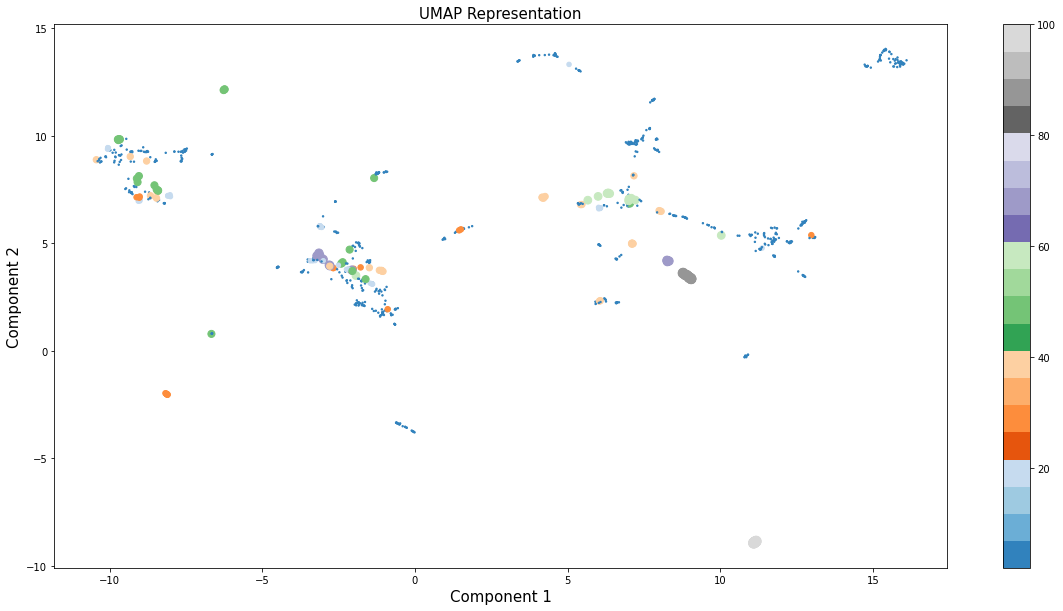

In [25]:
#scatter(u[:,0],u[:,1],s=2,c=cols,cmap="hsv")
scatter(u[:,0],u[:,1],s=ncol,c=ncol,cmap="tab20c")
colorbar()
title("UMAP Representation",fontsize=15)
xlabel("Component 1",fontsize=15)
ylabel("Component 2",fontsize=15)
figsize(20,10)

#### dbGAP

In [66]:
from sklearn.cluster import DBSCAN
dbg=DBSCAN(eps=0.15,metric="precomputed",min_samples=5).fit(distances)

In [67]:
dbg.labels_

array([ 0,  1,  1,  2,  2,  2,  2, -1, -1, -1, -1,  2,  2,  2,  2,  2, -1,
       -1, -1,  3,  3,  3,  3,  3,  3,  3,  4,  4, -1, -1,  5,  5,  5,  5,
       -1,  5,  5,  5, -1, -1, -1, -1, -1,  1,  3,  2,  2,  2,  2,  2, -1,
       -1, -1, -1,  6,  6,  6,  6,  6, -1,  7,  7,  7,  7,  7,  7,  7,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  8,  8,  8,  8,  8,
        8,  8, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1,
       -1, -1, -1, -1, -1,  2,  1,  1,  1,  8,  8,  8,  8,  8,  8,  2,  2,
        2,  2,  1, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  9,  9,  9,  9,  9,  2,  2, -1, -1,  1,  1, 10, 10,
       10, 10, 10, 10, 10,  4,  7,  7,  7, -1, -1,  9, -1, -1,  4,  4,  4,
        4,  4, 11, 11, 11, 11, 11,  2, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12,  8,  8,  8,  8,  8,  8,  8,  8,
        8, -1, -1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2

In [68]:
dbscanCols=[]
for i in dbg.labels_:
    if i==-1:
        dbscanCols.append(0)
    elif i==0:
        dbscanCols.append(25*10)
    else:
        if (i+1)%2==0:
            dbscanCols.append((i+1)*10)
        else:
            dbscanCols.append((i+1)*-10)

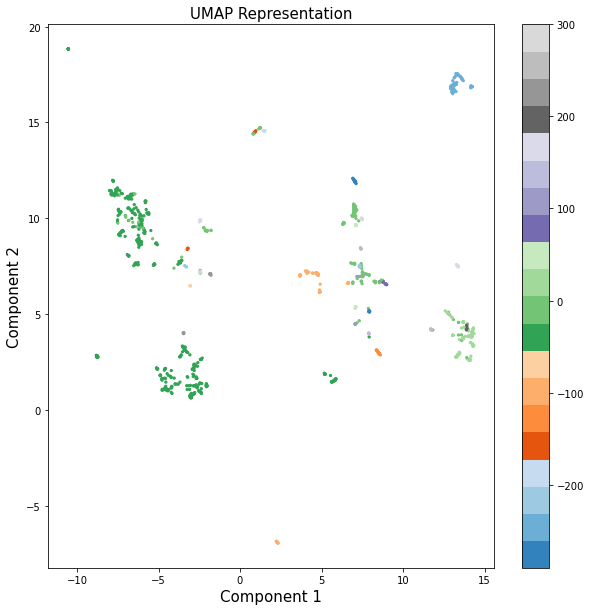

In [69]:
scatter(u[:,0],u[:,1],s=5,c=dbscanCols,cmap="tab20c")
colorbar()
title("UMAP Representation",fontsize=15)
xlabel("Component 1",fontsize=15)
ylabel("Component 2",fontsize=15)
figsize(10,10)

#### Mash Distance Analysis (All BioProjects)

In [59]:
group_distances=[]
diff_distances=[]

for i in range(1,distances.shape[0]):
    for j in range(0,i):
        if cols[i]==cols[j]:
            #if distances[i,j]==1.0:
                #print(i)
                #print(j)
                #print("===")
            group_distances.append(distances[i,j])
        else:
            #if distances[i,j]<0.1:
                #print(i)
                #print(j)
                #print("===")
            diff_distances.append(distances[i,j])

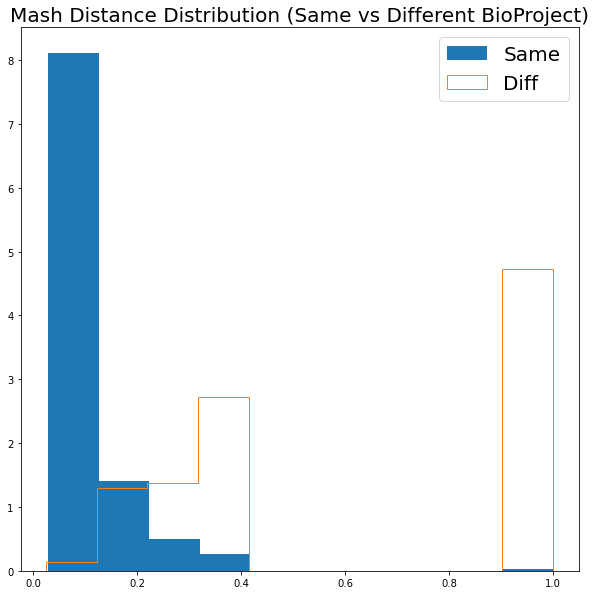

In [60]:
hist(group_distances,histtype='bar',label="Same", density=True)
hist(diff_distances,histtype='step',label="Diff", density=True)
title("Mash Distance Distribution (Same vs Different BioProject)", fontsize=20)
legend(prop={'size': 20})

In [15]:
from scipy.stats import ranksums,kstest

print(ranksums(group_distances,diff_distances))

print(kstest(group_distances,diff_distances))

RanksumsResult(statistic=-56.00472529162555, pvalue=0.0)
KstestResult(statistic=0.8276917859235711, pvalue=0.0)


#### Mash Distance Analysis (Keywords/MeSH Terms)

In [34]:
group_distances=[]
diff_distances=[]

for i in range(1,distances.shape[0]):
    for j in range(0,i):
        if ncol[i]==ncol[j]:
            #if distances[i,j]==1.0:
                #print(i)
                #print(j)
                #print("===")
            group_distances.append(distances[i,j])
        else:
            #if distances[i,j]<0.1:
                #print(i)
                #print(j)
                #print("===")
            diff_distances.append(distances[i,j])

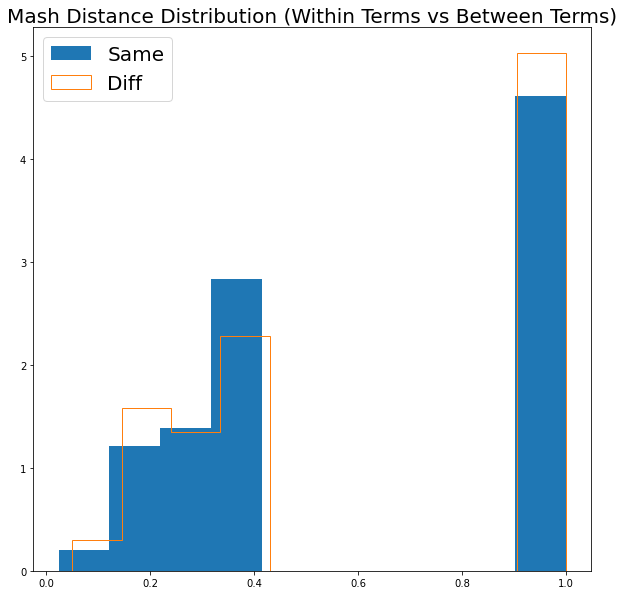

In [35]:
hist(group_distances,histtype='bar',label="Same", density=True)
hist(diff_distances,histtype='step',label="Diff", density=True)
title("Mash Distance Distribution (Within Terms vs Between Terms)", fontsize=20)
legend(prop={'size': 20})

In [36]:
from scipy.stats import ranksums,kstest

print(ranksums(group_distances,diff_distances))

print(kstest(group_distances,diff_distances))

RanksumsResult(statistic=-11.084708783413681, pvalue=1.4883393170118953e-28)
KstestResult(statistic=0.027448891609998527, pvalue=8.373346230555058e-71)


#### Test for Significant Differences in Clustering for Keywords

In [16]:
import statistics 
import random
def aleatorizationForTerms(dist,times,labels):
    differences=[]
    newlabels=labels
    for i in range(0,times):
        random.shuffle(newlabels)
        group_distances=[]
        diff_distances=[]

        for i in range(1,dist.shape[0]):
            for j in range(0,i):
                if newlabels[i]==newlabels[j]:
                    group_distances.append(dist[i,j])
                else:
                    diff_distances.append(dist[i,j])
        differences.append(statistics.median(diff_distances)-statistics.median(group_distances))
    differences.sort()
    return differences

In [17]:
from scipy.stats import ranksums,kstest
significant=[]
abSignificant=[]
abundance=[]
for term in kwordtoProj.keys():
    abundance.append(len(kwordtoProj[term]))
    if len(kwordtoProj[term])<5:
        continue
    print(term)
    ncol,thisColMap=change_col(kwordtoProj,[term],0)
    group_distances=[]
    diff_distances=[]

    for i in range(1,distances.shape[0]):
        for j in range(0,i):
            if ncol[i]==ncol[j]:
                group_distances.append(distances[i,j])
            else:
                diff_distances.append(distances[i,j])
    a,b=ranksums(group_distances,diff_distances)
    c,d=kstest(group_distances,diff_distances)
    actual_diff=statistics.median(diff_distances)-statistics.median(group_distances)
    Randdiff=aleatorizationForTerms(distances,1000,ncol)
    SignPos=int((len(Randdiff)*0.01))
    if b<0.01/(2*len(kwordtoProj)) and d<0.01/(2*len(kwordtoProj)) and Randdiff[SignPos]>actual_diff:
        abSignificant.append(len(kwordtoProj[term]))
        significant.append(term)
        print(term+"\t"+str(len(kwordtoProj[term])))

microbiota
16s rrna
microbiome
unclassified sequences
metagenome
organismal metagenomes
root metagenome
archaea
human gut metagenome
ecological metagenomes
seawater metagenome
gut microbiome
gut microbiome	10
soil metagenome
endophytes
ngs
diet
metagenomic sequencing
methane production
metagenomes
dna
rhizosphere
greenhouse
rhizosphere metagenome
mercury
chicken
gut microbiota
marine metagenome
16s
sediment metagenome
age
edna
escherichia coli
static coculture
diversity
lake water metagenome
mechanism
mechanism	7
feces metagenome
ammonia
metatranscriptome
pinus banksiana
aeciospores
endocronartium harknessii
salt marsh
cenococcum
lateral roots
mycorrhiza
plant metagenome
bat
metagenomic
sequencing
illumina
pathogen
pathogen	18
fungi
metabolism
bacterial communities
bacterial communities	8
viral
viral	6
gut
marine sediment metagenome
coal metagenome
peat metagenome
shoot metagenome
phosphate
nitrate
fjord
symbiosis
nitrogen-fixing consortium dg1
nitrogen-fixing consortium dg1	8
soil sur

Text(0, 0.5, 'Frequency')

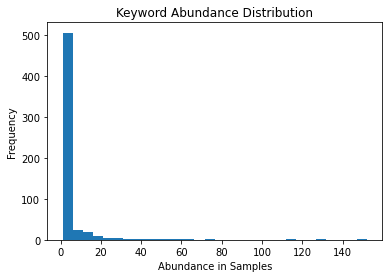

In [58]:
hist(abundance,histtype='bar', density=False,bins=30,)
title("Keyword Abundance Distribution")
xlabel("Abundance in Samples")
ylabel("Frequency")

In [52]:
abMeSH=[]
for i in MajMeSHtoProj.keys():
    abMeSH.append(len(MajMeSHtoProj[i]))

Text(0, 0.5, 'Frequency')

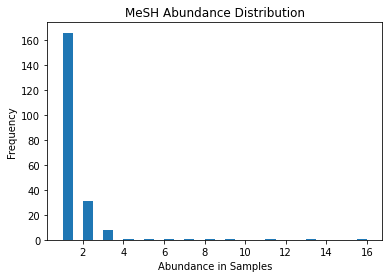

In [59]:
hist(abMeSH,histtype='bar', density=False,bins=30,)
title("MeSH Abundance Distribution")
xlabel("Abundance in Samples")
ylabel("Frequency")

#### Generate Metadata Table

In [37]:
MajMeSHtoProj
kwordtoProj
ids_map
projects
cols

keyIn=[]
for i in kwordtoProj.keys():
    if len(kwordtoProj[i])>4:
        keyIn.append(i)

table=open("DraftMetadata.tab","w")
header="id;Project"
for i in keyIn:
    header=header+"\t"+i
for j in MajMeSHtoProj:
    header=header+"\t"+j
table.write(header+"\n")

for i in range(len(ids_map)):
    line=str(ids_map[i])+"\t"+projects[cols[i]]
    for z in keyIn:
        if projects[cols[i]] in kwordtoProj[z]:
            line=line+"\t"+"Yes"
        else:
            line=line+"\t"+"No"
    for j in MajMeSHtoProj:
        if projects[cols[i]] in MajMeSHtoProj[j]:
            line=line+"\t"+"Yes"
        else:
            line=line+"\t"+"No"
    table.write(line+"\n")
table.close()